## 6. Decision Trees and Ensemble Learning

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### 6.2 Data cleaning and preparation

* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
#!wget $data

In [4]:
df = pd.read_csv('CreditScoring.csv')

In [5]:
df

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,2,1,1,60,39,2,1,1,69,92,0,0,900,1020
4451,1,22,2,60,46,2,1,1,60,75,3000,600,950,1263
4452,2,0,2,24,37,2,1,2,60,90,3500,0,500,963
4453,1,0,1,48,23,1,1,3,49,140,0,0,550,550


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Status     4455 non-null   int64
 1   Seniority  4455 non-null   int64
 2   Home       4455 non-null   int64
 3   Time       4455 non-null   int64
 4   Age        4455 non-null   int64
 5   Marital    4455 non-null   int64
 6   Records    4455 non-null   int64
 7   Job        4455 non-null   int64
 8   Expenses   4455 non-null   int64
 9   Income     4455 non-null   int64
 10  Assets     4455 non-null   int64
 11  Debt       4455 non-null   int64
 12  Amount     4455 non-null   int64
 13  Price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [9]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df['status'] = df['status'].map(status_values)

In [10]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df['home'] = df['home'].map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df['marital'] = df['marital'].map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df['records'] = df['records'].map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df['job'] = df['job'].map(job_values)

In [11]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [13]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [14]:
df = df[df.status!='unk'].reset_index(drop=True)

#### split the data

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_full_train.reset_index(drop=True)
df_test = df_val.reset_index(drop=True)

In [18]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [19]:
del df_train['status']
del df_val['status']
del df_test['status']

## 6.3 Decision trees

* How a decision tree looks like
* Training a decision tree
* Overfitting
* Controlling the size of a tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [21]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [22]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.9130798071353653

In [26]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

Retraining with different tree depth

In [27]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [28]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7662032905962834

In [29]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

0.7761016984958594

function to visulaize tree and conditions

In [30]:
from sklearn.tree import export_text

In [31]:
print(export_text(dt))

|--- feature_25 <= 0.50
|   |--- feature_27 <= 6.50
|   |   |--- feature_1 <= 862.50
|   |   |   |--- class: 0
|   |   |--- feature_1 >  862.50
|   |   |   |--- class: 1
|   |--- feature_27 >  6.50
|   |   |--- feature_12 <= 103.50
|   |   |   |--- class: 1
|   |   |--- feature_12 >  103.50
|   |   |   |--- class: 0
|--- feature_25 >  0.50
|   |--- feature_16 <= 0.50
|   |   |--- feature_12 <= 74.50
|   |   |   |--- class: 0
|   |   |--- feature_12 >  74.50
|   |   |   |--- class: 0
|   |--- feature_16 >  0.50
|   |   |--- feature_2 <= 8750.00
|   |   |   |--- class: 1
|   |   |--- feature_2 >  8750.00
|   |   |   |--- class: 0



In [32]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## 6.5 Decision trees parameter tuning

* selecting max_depth
* selecting min_samples_leaf

In [33]:
for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.622
   2 -> 0.696
   3 -> 0.766
   4 -> 0.802
   5 -> 0.823
   6 -> 0.844
   7 -> 0.860
   8 -> 0.878
   9 -> 0.888
  10 -> 0.894
  15 -> 0.912
  20 -> 0.912
None -> 0.910


In [34]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [35]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [36]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.802  0.823  0.842
5                 0.802  0.824  0.844
10                0.802  0.822  0.843
15                0.803  0.823  0.842
20                0.802  0.821  0.837
100               0.791  0.804  0.814
200               0.782  0.793  0.800
500               0.704  0.704  0.704

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

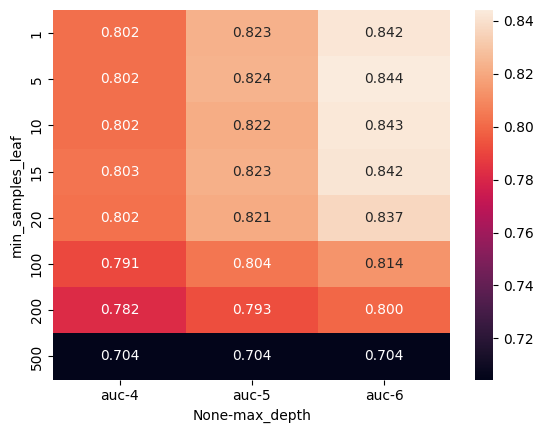

In [37]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [38]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## 6.6 Ensembles and random forest

* Board of experts
* Ensembling models
* Random forest - ensembling decision trees
* Tuning random forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [41]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

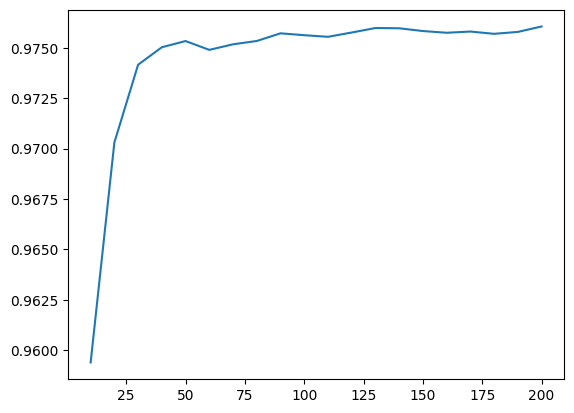

In [42]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [43]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [44]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

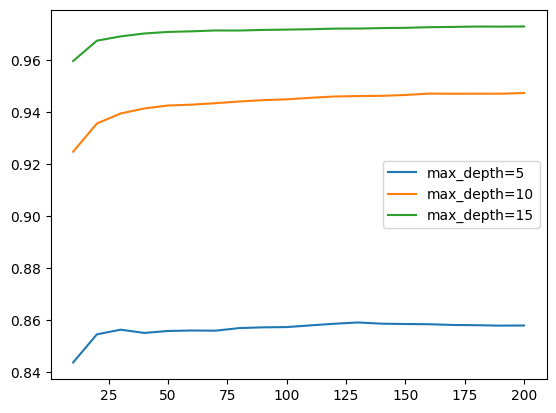

In [45]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [46]:
max_depth = 15

In [47]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [48]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

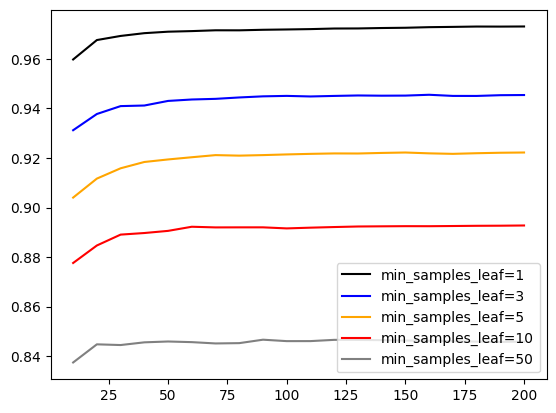

In [49]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [50]:
min_samples_leaf = 1

In [51]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6.7 Gradient boosting and XGBoost

* Gradient boosting vs random forest
* Installing XGBoost
* Training the first model
* Performance monitoring
* Parsing xgboost's monitoring output

In [52]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [54]:
import sys
sys.executable


'/opt/conda/bin/python'

In [56]:
! '/opt/conda/bin/python' -m pip install xgboost

  Using cached xgboost-3.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.28.7-py3-none-manylinux_2_18_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.1.1-py3-none-manylinux_2_28_x86_64.whl (115.9 MB)
Using cached nvidia_nccl_cu12-2.28.7-py3-none-manylinux_2_18_x86_64.whl (296.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]━━━ 1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/conda/bin/python -m pip install --upgrade pip


In [58]:
import xgboost as xgb

In [60]:
#Dmatrix data structure for xgboost
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [62]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [65]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9155512766323831

In [ ]:
# monitor perfromance with watchlist

In [66]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [68]:
%%capture output

xgb_params = {
    'eta': 0.3,          #learning rate
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',      # how to calculate the error,default is logloss

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,          # show important warnings
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)         #verbose eval:print every 5 steps

In [69]:
print(output.stdout)

[0]	train-auc:0.86653	val-auc:0.84426
[5]	train-auc:0.92969	val-auc:0.89856
[10]	train-auc:0.95512	val-auc:0.91879
[15]	train-auc:0.96767	val-auc:0.93093
[20]	train-auc:0.97648	val-auc:0.93805
[25]	train-auc:0.98248	val-auc:0.94252
[30]	train-auc:0.98844	val-auc:0.94772
[35]	train-auc:0.99244	val-auc:0.95121
[40]	train-auc:0.99393	val-auc:0.95228
[45]	train-auc:0.99568	val-auc:0.95443
[50]	train-auc:0.99723	val-auc:0.95615
[55]	train-auc:0.99804	val-auc:0.95726
[60]	train-auc:0.99861	val-auc:0.95825
[65]	train-auc:0.99916	val-auc:0.95909
[70]	train-auc:0.99962	val-auc:0.96026
[75]	train-auc:0.99975	val-auc:0.96067
[80]	train-auc:0.99989	val-auc:0.96138
[85]	train-auc:0.99993	val-auc:0.96148
[90]	train-auc:0.99998	val-auc:0.96160
[95]	train-auc:0.99999	val-auc:0.96181
[100]	train-auc:0.99999	val-auc:0.96191
[105]	train-auc:1.00000	val-auc:0.96178
[110]	train-auc:1.00000	val-auc:0.96189
[115]	train-auc:1.00000	val-auc:0.96203
[120]	train-auc:1.00000	val-auc:0.96216
[125]	train-auc:1.0000

## 6.8 XGBoost parameter tuning

Tuning the following parameters:
* eta
* max_depth
* min_child_weight